In [15]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pylab
from IPython.core.interactiveshell import InteractiveShell
from scipy.special import factorial
InteractiveShell.ast_node_interactivity = 'all'
pylab.rcParams['figure.figsize'] = (20.0, 8.0)

In [ ]:
# copied from Raphael, which manges the whole read file, concat and clean in one for loop, i managed in 3 functions!!!! 
days = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday']
df = None
for i,day in enumerate(days):
    new_df = pd.read_csv(f'../data/{day}.csv', sep=';')
    new_df['timestamp'] = pd.to_datetime(new_df['timestamp'], format="%Y-%m-%d %H:%M:%S")
    new_df['customer_no'] = day + '_' + new_df['customer_no'].astype(str)
    new_df.columns = new_df.columns.str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('___','').str.replace('_','')
    if i == 0:
        df = new_df
    else:
        df = pd.concat((df,new_df))

In [4]:
# get next_location and timedelta. time delta is the time for each customer move from one place to next. 
def get_next_location_timedelta(df, customerid_total):
    df['next_location']= None
    df['timedelta']= None
    for idno in customerid_total:
        df.loc[df['customerno']== idno,'next_location'] = df.loc[df['customerno']== idno,'location'].shift(-1).fillna('checkout')
        df.loc[df['customerno']== idno,'timedelta'] = df.loc[df['customerno']== idno,'timestamp'].shift(-1).fillna(np.nan)
    return df
customerid_total=df['customerno'].unique()
get_next_location_timedelta(df, customerid_total)

,timestamp,customerno,location,next_location,timedelta
0,2019-09-02 07:03:00,monday_1,dairy,checkout,2019-09-02 07:05:00
1,2019-09-02 07:03:00,monday_2,dairy,checkout,2019-09-02 07:06:00
2,2019-09-02 07:04:00,monday_3,dairy,checkout,2019-09-02 07:06:00
3,2019-09-02 07:04:00,monday_4,dairy,checkout,2019-09-02 07:08:00
4,2019-09-02 07:04:00,monday_5,spices,checkout,2019-09-02 07:05:00
...,...,...,...,...,...
5120,2019-09-06 21:50:00,friday_1500,dairy,checkout,NaT
5121,2019-09-06 21:50:00,friday_1507,checkout,checkout,NaT
5122,2019-09-06 21:50:00,friday_1508,checkout,checkout,NaT
5123,2019-09-06 21:50:00,friday_1509,drinks,checkout,NaT


# Time modelling

In [68]:
# each minute, how much customer. 
# df_p.groupby(pd.Grouper(freq='10Min')).aggregate(np.sum) # this is to check cutomer flow in 10 minutes interval. 

In [94]:
df_p=df.groupby(['location','timestamp'])['customerno'].count().unstack().fillna(0).T
df_p['sum'] = df_p.sum(axis=1)
df_p.head(5)
df_p.index.max()
df_p.index.min()

location,checkout,dairy,drinks,fruit,spices,sum
timestamp,,,,,,
2019-09-02 07:03:00,0.0,2.0,0.0,0.0,0.0,2.0
2019-09-02 07:04:00,0.0,2.0,0.0,1.0,3.0,6.0
2019-09-02 07:05:00,2.0,1.0,1.0,0.0,0.0,4.0
2019-09-02 07:06:00,2.0,2.0,1.0,2.0,1.0,8.0
2019-09-02 07:07:00,1.0,1.0,1.0,0.0,1.0,4.0


Timestamp('2019-09-06 21:50:00')

Timestamp('2019-09-02 07:03:00')

In [96]:
#df_p.to_csv('df_time.csv')

In [153]:
# manully calculating p for poisson.
customer_per_min = round(df_p['sum'].mean(),0)
minutes = 1

#Expected events
lam = customer_per_min * minutes
k = 3
p_k = np.exp(-lam) * np.power(lam,k)/factorial(k)
print(f'The probability of {k} customers in {minutes} minutes is {100*p_k:.2f}%.')

The probability of 3 customers in 1 minutes is 8.92%.


In [154]:
# calculate probability of k events happends in minutes given event_per_minute.
customer_per_min = round(df_p['sum'].mean())
minutes = 1
def cal_prob(customer_per_minute, minutes,k):
    lam = customer_per_minute * minutes
    return round(np.exp(-lam)*np.power(lam,k)/factorial(k),2)
minutes = 1    
cal_prob(customer_per_min, minutes,3)

0.09

In [155]:
# simulation 10 minutes.
customer_per_min = round(df_p['sum'].mean())
minutes = 1
#Expected events
lam = customer_per_min * minutes
customer_number = np.random.poisson(lam, 100)
(customer_number==3).mean()
customer_number

0.09

array([ 5,  5,  3,  4,  5,  8,  4,  8,  7,  3,  5,  5,  4,  7,  5, 10,  6,
        4,  3,  6,  6,  1,  6,  6,  1,  4,  7,  6,  4,  2,  4,  4,  5,  5,
        4,  5,  4, 10,  7,  6,  4,  7,  6,  6,  4,  9,  6,  2,  9,  3, 12,
        8,  6,  6,  4,  3,  4,  5,  4,  4,  4,  4, 10,  2,  5,  6,  6,  4,
        8,  3,  8,  4,  5,  8,  3,  7,  6,  0,  6,  6,  4,  7,  2,  6,  0,
        6,  6,  4, 11,  7,  6,  9,  8,  7,  5,  3, 10,  3,  7,  8])

In [ ]:
# -*- coding: utf-8 -*-

"""
   author: github@luochang212
   usage: python poisson.py [RATE] {TIME}
"""

import sys
import random
import collections
import matplotlib.pyplot as plt


class Poisson:
    def __init__(self, rate=sys.argv[1]):
        self.rate = int(rate)

        self.time = 1  # 单位时间
        if len(sys.argv) > 2 and sys.argv[2] != "":
            self.time = int(sys.argv[2])  # 手动指定时间范围

        self.EXP_NUM = 100000  # 实验次数
        self.NUM_LEVEL = 2  # 数量级

    def generator(self, prob):
        """仿真结果生成器"""
        while True:
            if random.random() < prob:
                yield 1
            else:
                yield 0

    def perform_exp(self, rate, time):
        """进行一次实验
        每次实验中，时间分片的数量比rate高两个数量级
        """
        level = len(str(rate))
        shard_num = 10 ** (level + self.NUM_LEVEL)  # 计算时间分片的数量

        gen = self.generator(rate / shard_num)

        cnt = 0
        for _ in range(time * shard_num):
            cnt += next(gen)
        
        return cnt

    def perform_exps(self, exp_num, rate, time):
        """多次实验，得到分布"""
        lst = []
        for _ in range(exp_num):
            lst.append(self.perform_exp(rate, time))

        return sorted(collections.Counter(lst).items(), key=lambda e: e[0])

    def draw(self, sorted_list):
        """画图"""
        s = sum([e[1] for e in sorted_list])
        x = [e[0] for e in sorted_list]
        y = [e[1] / s for e in sorted_list]

        plt.plot(x, y)
        
        plt.xlabel("k")
        plt.ylabel("P(k)")
        plt.show()

    def main(self):
        sorted_list = self.perform_exps(self.EXP_NUM, self.rate, self.time)
        self.draw(sorted_list)

    @staticmethod
    def calculator(rate, t, k):
        """用于计算泊松函数的概率 P(k|t,lambda)
           rate: lambda
           t: t
           k: k
        """
        import math
        return (rate * t) ** k / math.factorial(k) * math.exp(-rate * t)


if __name__ == '__main__':
    p = Poisson()
    p.main()


# calculate transition rate

In [75]:
df_transition = pd.crosstab(df['location'],df['next_location'],normalize=0)

In [100]:
#df[df.customerno.eq('monday_6')]

In [101]:
df_transition

next_location,checkout,dairy,drinks,fruit,spices
location,,,,,
checkout,1.000000,0.000000,0.000000,0.000000,0.000000
dairy,0.393033,0.000000,0.222483,0.189357,0.195127
drinks,0.537260,0.027145,0.000000,0.218950,0.216645
fruit,0.500195,0.237993,0.136080,0.000000,0.125732
spices,0.251998,0.323122,0.272776,0.152104,0.000000


In [82]:
#df_transition.to_csv('df_transition.csv',index=False)

In [83]:
#df.to_csv('customer_full.csv',index = False)

# 2 ways to generate ramdomly new customers

In [90]:
# generate next customer with transition matrix
def get_next_state(init_state):
    
    for i in df_transition.columns:
        possible_next_loc = df_transition.loc[i]
        next_state = np.random.choice(df_transition.columns, p=possible_next_loc)
    print(next_state)
    
init_state = np.random.choice(df_transition.index)
get_next_state('init_state')

dairy


In [89]:
# generate next customer with dictionary. 
location_dict={}
for location, next_location in zip(df['location'],df['next_location']):
    
    if location in location_dict.keys():
        # if the key is already there attach the current\
        # pair to the existing key
        location_dict[location].append(next_location)
    
    else:
        location_dict[location] = [next_location]

all_status = list(df['location'])
state_init = [np.random.choice(all_status)]
step = 0

for i in range(step):    
    
    state_init.append(np.random.choice(location_dict[state_init[i]]))

state_init

['drinks']

In [91]:
df.head(5)

,timestamp,customerno,location,next_location,timedelta
0,2019-09-02 07:03:00,monday_1,dairy,checkout,2019-09-02 07:05:00
1,2019-09-02 07:03:00,monday_2,dairy,checkout,2019-09-02 07:06:00
2,2019-09-02 07:04:00,monday_3,dairy,checkout,2019-09-02 07:06:00
3,2019-09-02 07:04:00,monday_4,dairy,checkout,2019-09-02 07:08:00
4,2019-09-02 07:04:00,monday_5,spices,checkout,2019-09-02 07:05:00


- Calculate the total number of customers in each section

<AxesSubplot:xlabel='location'>

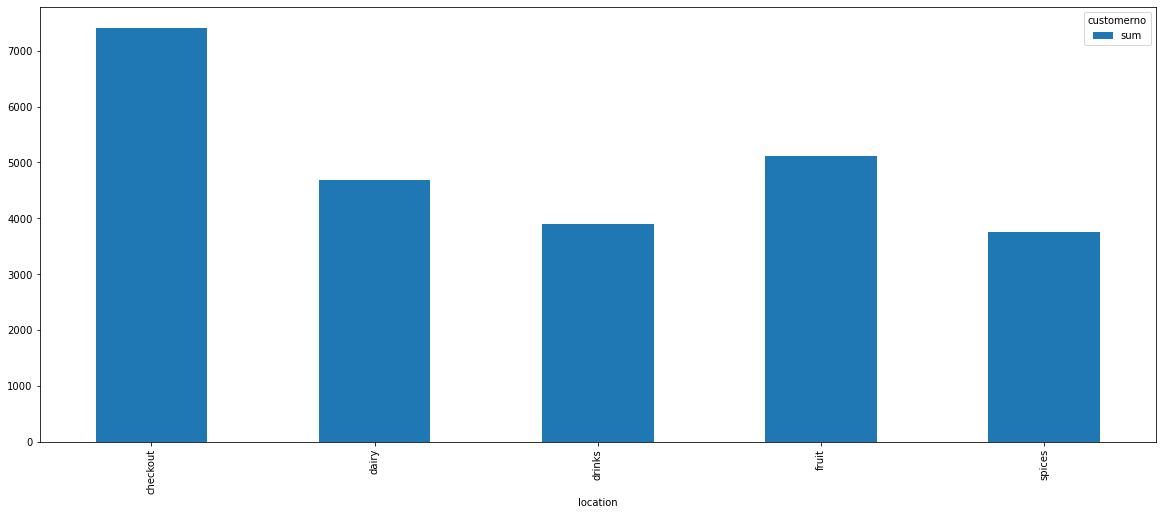

In [92]:
df_g=df.groupby(['location'])['customerno'].value_counts().unstack()# intresting, looks like one hot encode
df_g.fillna(0, inplace=True)
df_g['sum']=df_g.sum(axis=1)
df_g[['sum']].plot(kind='bar')

- Calculate the total number of customers in each section over time
- Display the number of customers at checkout over time

In [108]:
df.groupby(['location','timestamp'])['customerno'].count().unstack().fillna(0)

timestamp,2019-09-02 07:03:00,2019-09-02 07:04:00,2019-09-02 07:05:00,2019-09-02 07:06:00,2019-09-02 07:07:00,2019-09-02 07:08:00,2019-09-02 07:09:00,2019-09-02 07:10:00,2019-09-02 07:11:00,2019-09-02 07:12:00,...,2019-09-06 21:41:00,2019-09-06 21:42:00,2019-09-06 21:43:00,2019-09-06 21:44:00,2019-09-06 21:45:00,2019-09-06 21:46:00,2019-09-06 21:47:00,2019-09-06 21:48:00,2019-09-06 21:49:00,2019-09-06 21:50:00
location,,,,,,,,,,,,,,,,,,,,,
checkout,0.0,0.0,2.0,2.0,1.0,3.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,0.0,2.0
dairy,2.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,2.0,1.0
drinks,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
fruit,0.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,2.0,2.0,...,0.0,0.0,0.0,0.0,1.0,4.0,1.0,2.0,0.0,1.0
spices,0.0,3.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


<AxesSubplot:xlabel='timestamp'>

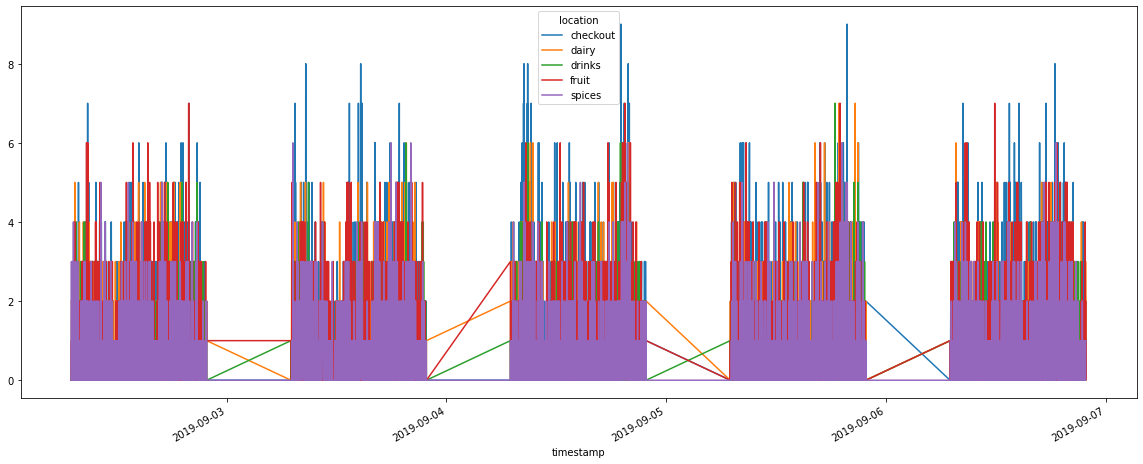

In [93]:
df.groupby(['location','timestamp'])['customerno'].count().unstack().fillna(0).T.plot()

- Calculate the time each customer spent in the market

In [114]:
def cal_time(df):
    timedelta = []
    customer_time = pd.DataFrame()
    for customerid in df['customerno'].unique():
        delta = df.loc[df['customerno']==customerid]['timestamp'].max() - df.loc[df['customerno']==customerid]['timestamp'].min()
        timedelta.append(delta)
    customer_time = pd.DataFrame({'customer_id':df['customerno'].unique(),
                             'timedelta':timedelta})
cal_time(df)

,timedelta
count,7445
mean,0 days 00:06:14.409670920
std,0 days 00:06:00.221984089
min,0 days 00:00:00
25%,0 days 00:02:00
50%,0 days 00:04:00
75%,0 days 00:08:00
max,0 days 00:52:00


,customer_id,timedelta
0,monday_1,0 days 00:02:00
1,monday_2,0 days 00:03:00
2,monday_3,0 days 00:02:00
3,monday_4,0 days 00:04:00
4,monday_5,0 days 00:01:00


<AxesSubplot:>

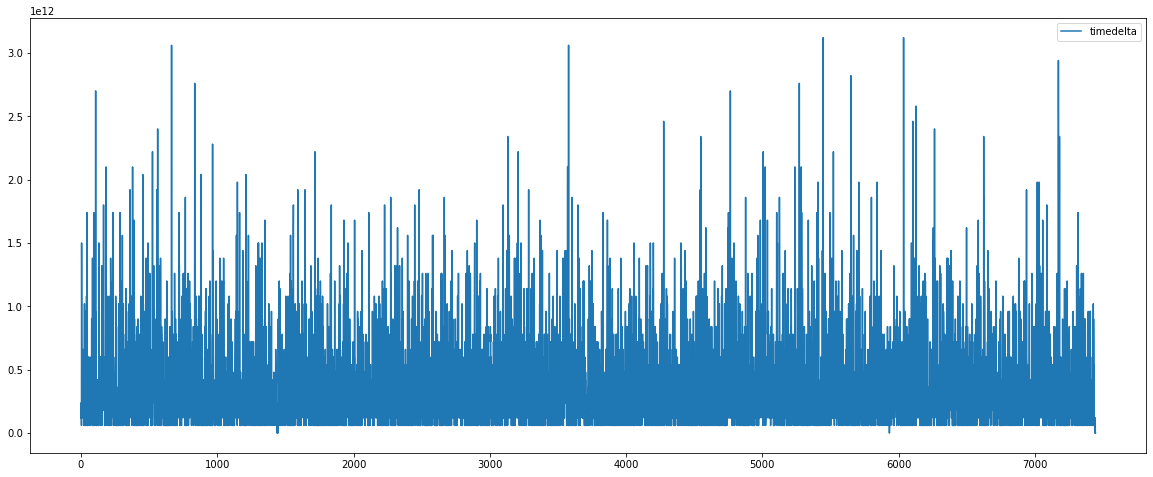

In [119]:
customer_time.describe()
customer_time.head(5)
customer_time.plot()

- Calculate the total number of customers in the supermarket over time.

In [127]:
len(df.customerno.unique())

7445

- Our business managers think that the first section customers visit follows a different pattern than the following ones. Plot the distribution of customers of their first visited section versus following sections (treat all sections visited after the first as “following”).

In [132]:
df.loc[df['customerno']=='monday_6']

,timestamp,customerno,location,next_location,timedelta
5,2019-09-02 07:04:00,monday_6,spices,dairy,2019-09-02 07:05:00
10,2019-09-02 07:05:00,monday_6,dairy,spices,2019-09-02 07:17:00
62,2019-09-02 07:17:00,monday_6,spices,drinks,2019-09-02 07:18:00
71,2019-09-02 07:18:00,monday_6,drinks,spices,2019-09-02 07:25:00
102,2019-09-02 07:25:00,monday_6,spices,dairy,2019-09-02 07:26:00
104,2019-09-02 07:26:00,monday_6,dairy,spices,2019-09-02 07:27:00
117,2019-09-02 07:27:00,monday_6,spices,checkout,2019-09-02 07:29:00
135,2019-09-02 07:29:00,monday_6,checkout,checkout,NaT
